In [1]:
import tensorflow as tf
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import cmath
import scipy.signal as signal
from scipy.signal import welch
from scipy.stats import skew
from scipy.stats import kurtosis

ModuleNotFoundError: No module named 'tensorflow'

In [4]:
mat = scipy.io.loadmat('GSMData.mat')

data = mat['arraydata_GSM']

In [5]:
def create_data(init=0, end=1000):
    X = []
    Y = []
    for dev in range(11):               #number of devices 12 
        for burst in  range(init, end):         # number of bursts 1000 for each device
            signal_data = data[burst, : , dev]
            #signal_data = down_sample(signal_data)
            x = np.array([[v.real for v in signal_data], [v.imag for v in signal_data]]) # values of the complex numbers in the array of data
            X.append(x.T)

            y = [dev]
            Y.append(y)
    
    return np.array(X), np.array(Y)

In [6]:
from numpy.random import permutation

x_train, y_train = create_data(end=800)
np.random.seed(10)
p = permutation(len(y_train))
#print(p)
x_train, y_train = x_train[p], y_train[p]

x_test, y_test = create_data(init=800, end=1000)

In [7]:
print(x_train.shape, x_test.shape)

(8800, 2600, 2) (2200, 2600, 2)


In [6]:
from keras.models import Sequential
from tensorflow.keras import datasets, models , layers
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D
from keras.optimizers import RMSprop,Adam

In [7]:
model = models.Sequential()
model.add(layers.Conv1D(32, 1, input_shape=(2600, 2), activation='relu', padding='same')) # 2 is the values, 2600 is the samples for each burst
#model.add(BatchNormalization())
model.add(layers.MaxPooling1D())
model.add(Dropout(0.1))
model.add(layers.Conv1D(64, 1 , activation='relu'))
model.add(layers.MaxPooling1D())
model.add(Dropout(0.1))
model.add(layers.Conv1D(96, 2, activation='relu'))
model.add(layers.MaxPooling1D())
#model.add(layers.Conv1D(100, 2, activation='relu'))
#model.add(layers.MaxPooling1D())
model.add(Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(30, activation='relu'))
model.add(Dropout(0.15))
model.add(layers.Dense(11, activation='linear')) # linear because I use down the (from_logits = True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2600, 32)          96        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1300, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1300, 32)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1300, 64)          2112      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 650, 64)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 650, 64)           0

In [40]:
from keras import optimizers 
optimizer = optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= 'accuracy')

history = model.fit(x_train, y_train, epochs=5, batch_size = 128,
                   validation_data=(x_test, y_test))

Epoch 1/5
69/69 [==============================] - 52s 731ms/step - loss: 0.8898 - accuracy: 0.5735 - val_loss: 0.7582 - val_accuracy: 0.6777
Epoch 2/5
69/69 [==============================] - 50s 731ms/step - loss: 0.8434 - accuracy: 0.5856 - val_loss: 0.6990 - val_accuracy: 0.6314
Epoch 3/5
69/69 [==============================] - 50s 721ms/step - loss: 0.8516 - accuracy: 0.5894 - val_loss: 0.7113 - val_accuracy: 0.6777
Epoch 4/5
69/69 [==============================] - 51s 734ms/step - loss: 0.8571 - accuracy: 0.5865 - val_loss: 0.7007 - val_accuracy: 0.7136
Epoch 5/5
69/69 [==============================] - 50s 723ms/step - loss: 0.8646 - accuracy: 0.5798 - val_loss: 0.7664 - val_accuracy: 0.5982


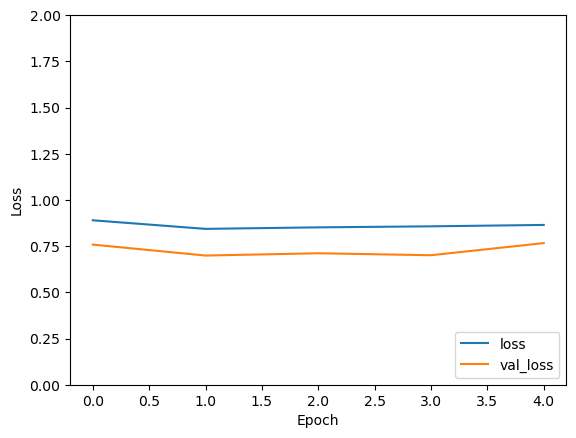

In [41]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')

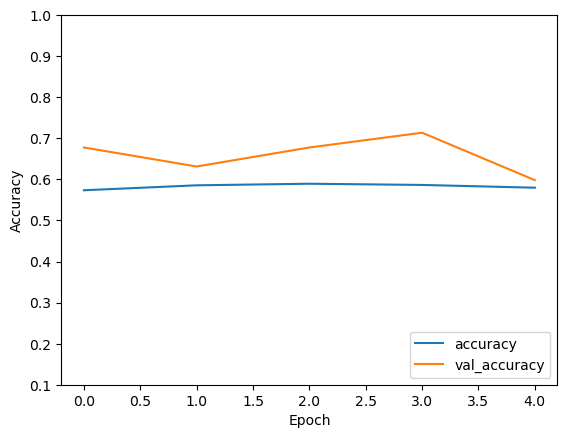

In [42]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

69/69 [==============================] - 3s 35ms/step


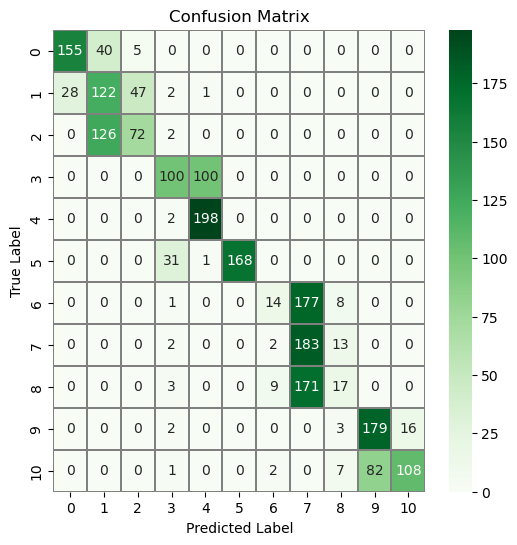

In [43]:
from sklearn.metrics import confusion_matrix
import sklearn as sl
import seaborn as sns

# confusion matrix

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = y_test.reshape(-1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.0f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [78]:
def create_test_data(init=0, end=1000):
    X = []
    Y = []
    dev=11 #device 12 
    for burst in  range(init, end):         # number of bursts 1000 for each device
        signal_data = data[burst, : , dev]
        #signal_data = down_sample(signal_data)
        x = np.array([[v.real for v in signal_data], [v.imag for v in signal_data]]) # values of the complex numbers in the array of data
        X.append(x.T)
        y = [dev]
        Y.append(y)
    
    return np.array(X), np.array(Y)


In [79]:
x_test12, y_test12 = create_test_data(init=0, end=1000)

TypeError: list indices must be integers or slices, not tuple

In [73]:
x_test12.shape

(1000, 2600, 2)

32/32 [==============================] - 1s 33ms/step


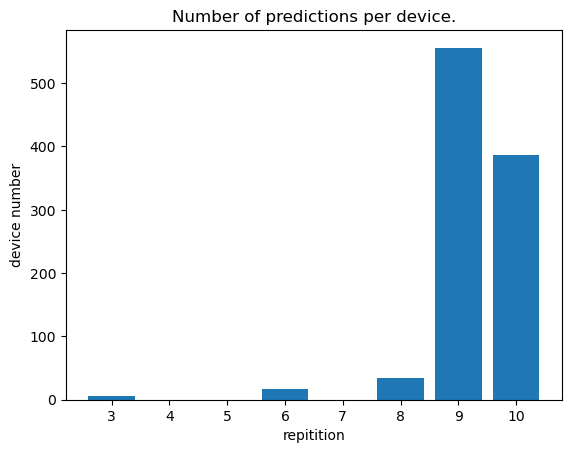

In [74]:


# Predict the values from the validation dataset
Y_pred = model.predict(x_test12)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = y_test12.reshape(-1)


devices,repitition=np.unique(Y_pred_classes, return_counts=True)
# creating the bar plot
plt.bar(devices, repitition)
 
plt.xlabel("repitition")
plt.ylabel("device number")
plt.title("Number of predictions per device.")
plt.show()



In [77]:
from tabulate import tabulate
#define header names
col_names = ["device number", "repitition"]
table=[]
for i in range(0,len(devices)):
    table.append([devices[i],repitition[i]])

print(tabulate(table, headers=col_names))

  device number    repitition
---------------  ------------
              3             6
              6            17
              8            34
              9           556
             10           387
